# Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -q kaggle

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow import keras
%load_ext tensorboard


import os

# Data Loading

The code defines a function `create_kaggle_dir()` to create a directory named ".kaggle" in the root directory "/root/" if it does not exist. 

The next function, `retrieve_kaggle_json()`, retrieves the kaggle.json file from a specified source directory and places it in the ".kaggle" directory. The file is used for authentication when using the Kaggle API. The function sets appropriate file permissions using chmod.

The next two functions, `download_facemask_dataset()` and `unzip_facemask_dataset()`, download and unzip a face mask detection dataset respectively if it does not already exist in the "/content/" directory.

The final function, `dataset_pipeline()`, calls all the above functions in the following order - `create_kaggle_dir()`, `retrieve_kaggle_json()`, `download_facemask_dataset()`, and `unzip_facemask_dataset()`.

The last line of the code executes the `dataset_pipeline()` function. This code can be useful for setting up the required dataset for a machine learning project related to face mask detection.

In [4]:
def create_kaggle_dir(kaggle_dir="/root/.kaggle/"):
    if not os.path.exists(kaggle_dir):
        !mkdir $kaggle_dir

def retrieve_kaggle_json(source_dir="/content/drive/MyDrive/", kaggle_dir="/root/.kaggle/", file_name="kaggle.json"):
    source_file = os.path.join(source_dir, file_name)
    target_file = os.path.join(kaggle_dir, file_name)

    if not os.path.exists(target_file):
        !cp $source_file $kaggle_dir
        !chmod 600 $target_file

def download_facemask_dataset():
    if not os.path.exists("/content/face-mask-detection.zip"):
        !kaggle datasets download -d dhruvmak/face-mask-detection

def unzip_facemask_dataset():
    if not os.path.exists("/content/face-mask-detection"):
        !unzip face-mask-detection.zip -d face-mask-detection > /dev/null 2>&1

def dataset_pipeline():
    create_kaggle_dir()
    retrieve_kaggle_json()
    download_facemask_dataset()
    unzip_facemask_dataset()

dataset_pipeline()

 99% 192M/194M [00:07<00:00, 34.5MB/s]
100% 194M/194M [00:07<00:00, 28.8MB/s]


In [5]:
IMG_SIZE = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0, 
                                                          shear_range=0.2, 
                                                          zoom_range=0.2, 
                                                          rotation_range=45, 
                                                          horizontal_flip=True, 
                                                          validation_split=0.2)

The code uses the Keras `ImageDataGenerator` class to create two data generators named `train` and `test`. 

The `flow_from_directory()` method of the `ImageDataGenerator` class is used to load the training and validation datasets from the specified directory '/content/face-mask-detection/dataset/'. The images in the directory are resized to the specified `IMG_SIZE` and augmented by the `datagen` object. 

Both the training and validation datasets are loaded as batches of 16 images at a time, with the `class_mode` argument set to 'binary' as there are only two classes (with mask and without mask) in the dataset. The `interpolation` argument is set to 'lanczos' for better image quality. 

The `subset` argument is set to 'training' for the `train` data generator and 'validation' for the `test` data generator to specify the type of dataset to be loaded. Finally, the `shuffle` argument is set to `True` to shuffle the order of the images during training and testing.

In [6]:
train = datagen.flow_from_directory('/content/face-mask-detection/dataset/', target_size=(IMG_SIZE,IMG_SIZE), batch_size=16, 
                                    class_mode='binary', interpolation='lanczos', shuffle=True, subset='training')

test = datagen.flow_from_directory('/content/face-mask-detection/dataset/', target_size=(IMG_SIZE,IMG_SIZE), batch_size=16, 
                                    class_mode='binary', interpolation='lanczos', shuffle=True, subset='validation')

Found 352 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


# Model Creation

The following code defines a deep learning model using the Keras `Sequential` API. 

The model architecture consists of several layers, including a pre-trained `MobileNet` layer, followed by a `Conv2D` layer, a `Flatten` layer, and a `Dense` layer. 

The input shape of the model is specified using the `Input` layer. The `IMG_SIZE` is used to set the height and width of the input image, and `3` specifies the number of color channels.

The model is compiled using the `compile()` method, which specifies the loss function, optimizer, and evaluation metric. The `binary_crossentropy` loss function is used since the dataset has only two classes. The `rmsprop` optimizer is used to minimize the loss function during training, and `accuracy` is used as the evaluation metric.

Finally, the `summary()` method is used to display the model summary, which shows the layer-wise structure of the model and the number of parameters in each layer.

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((IMG_SIZE,IMG_SIZE,3)),
    tf.keras.applications.MobileNet(include_top=False, weights='imagenet'),
    tf.keras.layers.Conv2D(3, 3, padding='same', activation='sigmoid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 3)           27651     
                                                                 
 flatten (Flatten)           (None, 147)               0         
                                                                 
 dense (Dense)               (None, 1)                 148       
                                                                 
Total params: 3,256,663
Trainable params: 3,234,775
Non-trainable params: 21,888
_________________________________________________________________


In [8]:
model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
22/22 [==============================] - 42s 774ms/step - loss: 0.3075 - accuracy: 0.8580 - val_loss: 0.7861 - val_accuracy: 0.5227
Epoch 2/5
22/22 [==============================] - 16s 747ms/step - loss: 0.1159 - accuracy: 0.9716 - val_loss: 0.1688 - val_accuracy: 0.9659
Epoch 3/5
22/22 [==============================] - 17s 762ms/step - loss: 0.0639 - accuracy: 0.9858 - val_loss: 0.7387 - val_accuracy: 0.6136
Epoch 4/5
22/22 [==============================] - 16s 727ms/step - loss: 0.0319 - accuracy: 0.9972 - val_loss: 0.1478 - val_accuracy: 0.9318
Epoch 5/5
22/22 [==============================] - 16s 744ms/step - loss: 0.0396 - accuracy: 0.9886 - val_loss: 0.0345 - val_accuracy: 1.0000


In [9]:
model.evaluate(test)

6/6 [==============================] - 3s 464ms/step - loss: 0.0379 - accuracy: 1.0000


[0.03790757432579994, 1.0]

## Predict Custom Images

The code defines a function named `predict` that takes a file path as input.

The function loads an image from the specified file path using the `load_img` method of `keras.preprocessing.image`. The image is then resized to the specified `IMG_SIZE` and converted to a NumPy array using the `img_to_array` method. 

The pixel values of the image are normalized by dividing with 255.0. The model is then used to predict whether the image contains a person wearing a mask or not, by passing the processed image as input to the `predict` method of the `model` object. 

The predicted result is stored in the `pred` variable as a probability value. The image is then plotted using `matplotlib.pyplot.imshow` and a title is added to the plot using `plt.title`. The title displays the predicted class and the corresponding probability score in percentage.

If the predicted probability value is greater than 0.5, the image is classified as 'Without Mask' and if it is less than or equal to 0.5, the image is classified as 'With Mask'.

In [ ]:
def predict(path) :
    img = tf.keras.preprocessing.image.load_img(path, target_size=(IMG_SIZE,IMG_SIZE), interpolation='lanczos')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    pred = model.predict(np.array([img]))
    plt.imshow(img)
    if pred[0][0] > 0.5 : 
        plt.title(f'Without Mask : {pred[0][0]*100 : 0.2f}%')
    else : 
        plt.title(f'With Mask : {(1-pred[0][0])*100 : 0.2f}%')

1/1 [==============================] - 0s 22ms/step


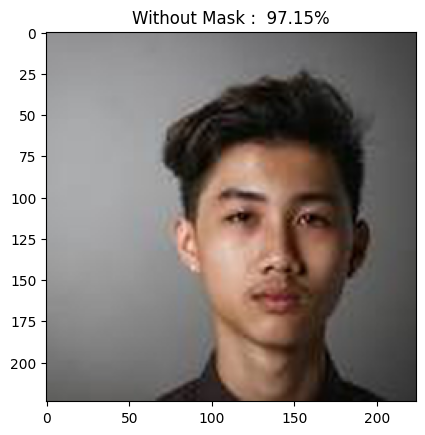

In [ ]:
path = "/content/no-mask-2.jpeg"
predict(path)